First part of laboratories were conducted by <a href="https://github.com/makskliczkowski">Maksymilian Kliczkowski</a>. He created notebooks we used in laboratories and he help me and my friends with understanding basic and advanced topics in machine learning. I am really glad that I had him as a tutor.

In first course of ML/AI we were build ML models from the ground using math.

In this notebook I will present only some task we had as a homework from notebook about scikit-learn

Data use throughout the notebook

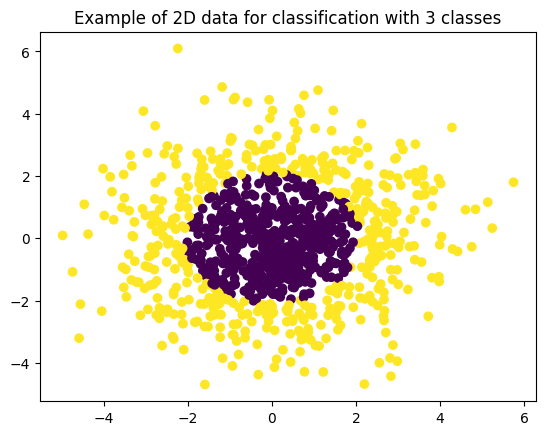

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

your_idx            = 420

# use that data throught the notebook
X, y = make_classification(
    n_samples       =   1000,           # observations
    n_features      =   10,             # total features
    n_informative   =   8,              # 'useful' features
    n_classes       =   5,              # target/label
    random_state    =   your_idx        # put your unique results here
)
X2d, y2d = make_gaussian_quantiles(
    cov             =   3.,
    n_samples       =   1000,
    n_features      =   2,
    n_classes       =   2,
    random_state    =   your_idx)

plt.scatter(X2d[:, 0], X2d[:, 1], c = y2d)
plt.title("Example of 2D data for classification with 3 classes")

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.1, random_state = your_idx)
X_train2d, X_test2d, Y_train2d, Y_test2d = train_test_split(X2d, y2d, test_size = 0.1, random_state = your_idx)

## KNN

#### Implement the following naive algorithm for k-NN. Algorithm for prediction involves [1pt]:
1. Set the memory for initial distances vector to.
2. Set the vector of frequencies of size $k$ to zeros
3. For all samples i $\leftarrow N$ do:
    1. current_distance $(i) \leftarrow d(X_i, \rm point)$
4. Sort distances up and take $k$-first elements.
5. Go through those elements and set the frequency of classes occurance.
6. Take the class with the highest occurance rate.

- plot the outliers
- check the accuracy
- define the distance measure
- test the algorithm on both datasets

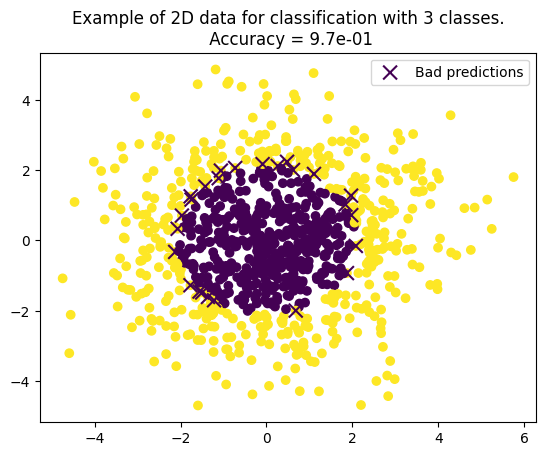

In [2]:
measure      =  lambda x,y : np.sqrt(np.sum((x-y)**2))
def classify(point,
             Xtrain,
             Ytrain,
             k   :  int,
             cat :  int,
             measure):
    dist = np.zeros((len(Xtrain),2))
    for i, x in enumerate(Xtrain):
      dist[i] = [measure(point,x), Ytrain[i]]
    dist = dist[dist[:, 0].argsort()]
    kn = dist[:k]
    unique = np.unique(kn[:,1])
    return unique[0]

# predict samples

predictions = []
for x in X_train2d:
    predictions.append(classify(x, X_train2d, Y_train2d, 3, 2, measure))

predictions     = np.array(predictions)
badPredictions  = predictions[predictions != Y_train2d]
badSamples      = X_train2d[predictions != Y_train2d]

plt.scatter(X_train2d[:, 0], X_train2d[:, 1], c = Y_train2d)
plt.title(f"Example of 2D data for classification with 3 classes.\n Accuracy = {np.sum(predictions == Y_train2d) / len(predictions):.1e}")
plt.scatter(badSamples[:, 0], badSamples[:, 1], c = badPredictions, marker = 'x', s = 100, label = 'Bad predictions')
plt.legend()

## K-mean clustering

#### Implement the following naive algorithm for k-means:

1. Initialization: Choose the number of clusters that you want to identify in the dataset. Randomly initialize cluster centroids. Each centroid represents the center of a cluster.
2. Assignment: For each data point in the dataset, calculate the squared Euclidean distance to each centroid. Assign the data point to the cluster whose centroid is the closest.
3. Update: Recalculate the centroids of the clusters based on the mean of all data points assigned to each cluster.
4. Repeat: Repeat the Assignment and Update steps iteratively until convergence, which occurs when the centroids no longer change significantly or a predefined number of iterations is reached.
5. Output: After given number of iterations or insignificant change of clusters set the final results.

- plot the outliers
- check the accuracy
- define the distance measure
- test the algorithm on both datasets

[[0, array([-2.81416174, -1.47473013])], [0, array([-1.29355977, -1.799036  ])], [0, array([-1.13982731, -1.45175315])], [1, array([0.49773955, 0.69354965])], [0, array([-0.14820032,  0.1392441 ])], [1, array([0.63886347, 4.15253113])], [0, array([ 0.34262739, -0.78025832])], [0, array([ 0.70007105, -3.25850119])], [0, array([-2.73873031, -1.36923211])], [0, array([-3.46265584, -1.88191515])], [1, array([ 1.87198582, -0.93077975])], [0, array([-2.48940396,  2.96514706])], [0, array([ 0.30863255, -0.56927615])], [1, array([1.08656295, 0.41563565])], [0, array([ 0.03546397, -2.38834527])], [1, array([2.09201705, 0.56418866])], [1, array([2.0903872 , 0.48721604])], [1, array([2.28128846, 1.07233097])], [0, array([-2.39392929,  0.45089859])], [1, array([ 2.32951454, -0.92087699])], [0, array([ 0.4050445 , -2.14958752])], [0, array([-1.41344419, -1.35285979])], [1, array([ 0.88186022, -0.03541769])], [0, array([-3.76365714,  0.59473268])], [0, array([ 0.55921439, -0.7541796 ])], [1, array([

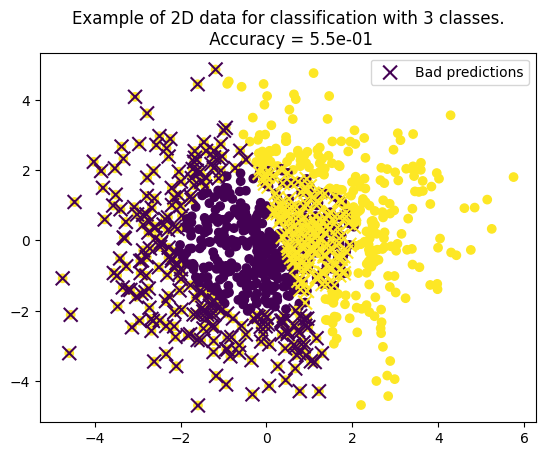

In [15]:
measure         =   lambda x,y : np.sqrt(np.sum((x-y)**2))

# predict data
def kmeansPredict(clusters, distance, X):
    dist = np.inf
    dist_idx = None
    for i, centroid in enumerate(clusters):
      d = distance(X, centroid)
      if d < dist:
        dist = d
        dist_idx = i
    return dist_idx

def kmeans(X,
           k            : int,
           distance,
           iterations   = 1000,
           seed         = 253880):
    centroids = []
    for _ in range(k):
      centroids.append([np.random.random(2)])
    assign = []
    for j, x in enumerate(X):
      dist = np.inf
      dist_idx = 0
      for i, centroid in enumerate(centroids):
        d = distance(x, centroid)
        if d < dist:
          dist = d
          dist_idx = i
      assign.append([dist_idx, x])
    assign = np.array(assign, dtype=object)
    
    for k_i in range(k):
      centroids[k_i] = np.mean(assign[assign[:, 0]==k_i][:,1])
    return centroids

# train me!
clusters = kmeans(X_train2d, k = 2, distance = measure, iterations = 50)

# predict samples
predictions = []
for x in X_train2d:
    predictions.append(kmeansPredict(clusters, measure, x))

predictions     = np.array(predictions)
badPredictions  = predictions[predictions != Y_train2d]
badSamples      = X_train2d[predictions != Y_train2d]

plt.scatter(X_train2d[:, 0], X_train2d[:, 1], c = Y_train2d)
plt.title(f"Example of 2D data for classification with 3 classes.\n Accuracy = {np.sum(predictions == Y_train2d) / len(predictions):.1e}")
plt.scatter(badSamples[:, 0], badSamples[:, 1], c = badPredictions, marker = 'x', s = 100, label = 'Bad predictions')
plt.legend()

## DBSCAN Clustering

#### Implement the following naive algorithm for DBSCAN. [1pt]:

1. Choose a random data point and check its neighbors within `eps` range.
2. Check whether the point is a core point, border point or an outlier.
3. If it is a core point (has more points than `minPts`), apply the search for its neighbors.
4. If it is a border, add it to the cluster but search for a starting point again #1.
5. If it is an outlier, mark it as such and search for a starting point again #1.

- plot the outliers
- check the accuracy
- define the distance measure
- test the algorithm on both datasets

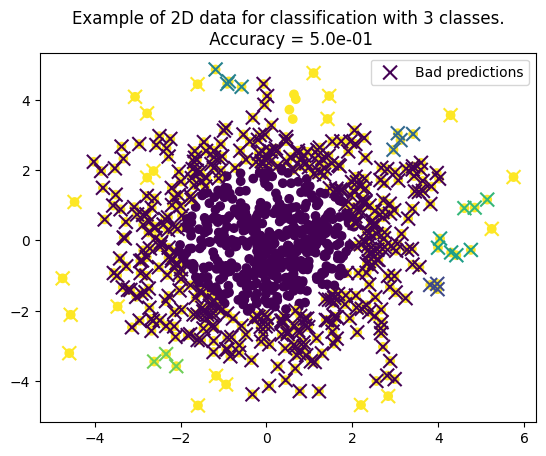

In [16]:
from ast import copy_location
import random
def check_point_character(  eps     :   float,
                            minPts  :   int,
                            X_train,
                            idx     :   int
                        ):
    """
    This function shall first check the distance of a given point to each other point.
    Then it decides how to classify it with one hot encoding.
    """
    dist = []
    for i, x in enumerate(X_train):
      dist.append([int(i), measure(x, X_train[idx])])
    dist = np.array(dist)
    sorter = lambda x: (x[1])
    dist = sorted(dist, key=sorter)
    dist = np.array(dist)
    point_idx = np.argwhere(dist[1:,1]<=eps) + 1
    point_idx = point_idx.T[0]
    point_idx = dist[point_idx.astype(int)].astype(int)
    numbOfPoints = len(point_idx)
    if numbOfPoints >= minPts:
      return np.array([0,0,1]), point_idx.T[0]  #core
    elif numbOfPoints > 0:
      return np.array([0,1,0]), point_idx.T[0]  #border
    else:
      return np.array([1,0,0]), point_idx.T[0]  #outlier

check_point_character(5e-1, 5, X_train2d, 0)

def neighbors(point, x_train_class, minPts, neighbors_list, cluster):
    if len(neighbors_list) < minPts:
      return neighbors_list
    for nn in neighbors_list:
      if nn not in cluster:
        cluster.add(nn)
        newnn = neighbors(nn, x_train_class, minPts, x_train_class[nn][2], cluster)
        for nw in newnn:
          cluster.add(nw)
    return cluster

def cluster_me_please(eps : float, minPts : int, X_train):
    # start with the first cluster, 0 will be considered as noise
    x_train_class = []
    for i, x in enumerate(X_train):
      cat, nn = check_point_character(eps, minPts, X_train, i)
      x_train_class.append(np.array([np.array([int(i)]), cat, nn],dtype=object))
    corePoint = []
    borderPoint = []
    outlierPoint = []
    for pC in x_train_class:
      if (pC[1]==np.array([0,0,1])).all():
        corePoint.append(pC)
      elif (pC[1]==np.array([0,1,0])).all():
        borderPoint.append(pC)
      else:
        outlierPoint.append(pC)
    CPY = []
    idxx = 0
    points_in_cluster = 0
    all_cpy = []
    while points_in_cluster < len(X_train)- len(outlierPoint):

        points_in_cluster = 0
        cluster = set()
        cluster = list((neighbors(corePoint[idxx][0], x_train_class, minPts,corePoint[idxx][2], cluster)))
        idxx = -1
        CPY.append(cluster)
        all_cpy = all_cpy + cluster
        in_cpy = True
        for i in range(len(X_train)):
            if i not in all_cpy:
              if (x_train_class[i][1]==np.array([0,0,1])).all():
                idxx=i
                break
        for i, cP in enumerate(corePoint):
          if cP[0] == idxx:
            idxx = i
        for i in range(len(CPY)):
          points_in_cluster += len(CPY[i])
        if idxx == -1:
          break

    Y = np.ones(len(X_train)) * (len(CPY)+1)
    for i, CPY_i in enumerate(CPY):
      for cp in CPY_i:
        Y[cp] = i

    return Y




predictions     = cluster_me_please(5e-1, 2, X_train2d)
badPredictions  = predictions[predictions != Y_train2d]
badSamples      = X_train2d[predictions != Y_train2d]

plt.scatter(X_train2d[:, 0], X_train2d[:, 1], c = Y_train2d)
plt.title(f"Example of 2D data for classification with 3 classes.\n Accuracy = {np.sum(predictions == Y_train2d) / len(predictions):.1e}")
plt.scatter(badSamples[:, 0], badSamples[:, 1], c = badPredictions, marker = 'x', s = 100, label = 'Bad predictions')
plt.legend()


## Implement PCA from scratch

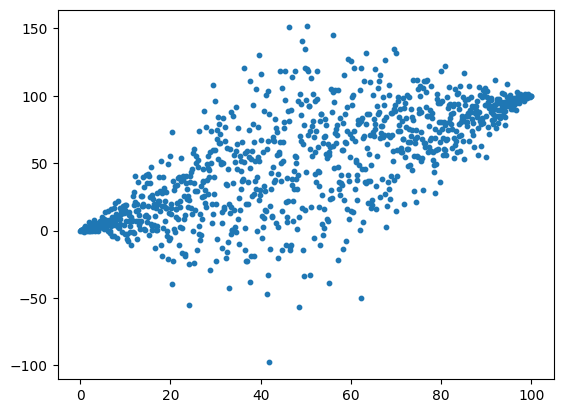

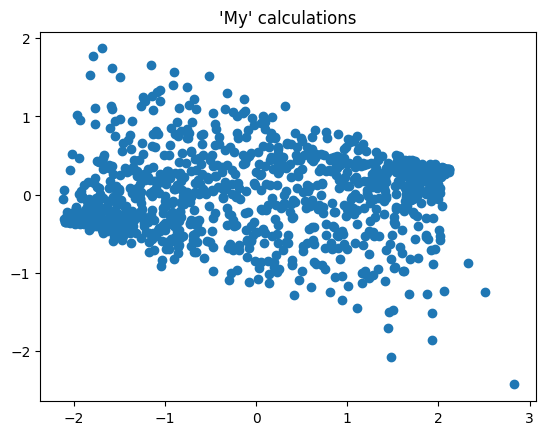

[[ 2.12010416e+00]
 [ 2.11353860e+00]
 [ 2.10625879e+00]
 [ 2.11176611e+00]
 [ 2.09827870e+00]
 [ 2.09317674e+00]
 [ 2.08638311e+00]
 [ 2.09703906e+00]
 [ 2.06148248e+00]
 [ 2.11511514e+00]
 [ 2.09123795e+00]
 [ 2.03441109e+00]
 [ 2.04858920e+00]
 [ 2.05443968e+00]
 [ 2.05822893e+00]
 [ 2.08964602e+00]
 [ 2.03566140e+00]
 [ 2.06118533e+00]
 [ 2.03470432e+00]
 [ 2.07595077e+00]
 [ 1.95836608e+00]
 [ 2.01182520e+00]
 [ 2.07323131e+00]
 [ 2.00023476e+00]
 [ 1.98879716e+00]
 [ 1.99791563e+00]
 [ 2.05602258e+00]
 [ 2.03663398e+00]
 [ 1.99003007e+00]
 [ 1.97934372e+00]
 [ 1.94703124e+00]
 [ 1.90675221e+00]
 [ 1.95774875e+00]
 [ 2.03871957e+00]
 [ 2.00265724e+00]
 [ 1.93757354e+00]
 [ 1.99823917e+00]
 [ 2.00499943e+00]
 [ 2.01475668e+00]
 [ 2.02552649e+00]
 [ 2.00465334e+00]
 [ 1.98068855e+00]
 [ 1.96125628e+00]
 [ 1.88552267e+00]
 [ 1.91966696e+00]
 [ 1.89176197e+00]
 [ 1.87772777e+00]
 [ 1.95924082e+00]
 [ 1.82368692e+00]
 [ 1.90701419e+00]
 [ 1.94958998e+00]
 [ 1.85332392e+00]
 [ 1.9661042

In [17]:
x       =   np.linspace(0, 100, num = 1000)
data    =   x.copy()
for i,ii in enumerate(x):
    sig =   ii if i < len(x) // 2 else x[-1] - ii
    data[i] = x[i] + np.random.normal(0.0, sig)

plt.scatter(x, data, s = 10)
plt.show()
x_mean = np.mean(x)
x_STD = np.std(x)
data_mean = np.mean(data)
data_STD = np.std(data)
stand_X = (x-x_mean)/x_STD
stand_DATA = (data - data_mean)/data_STD
COV_MATRIX = np.zeros((2,2))
COV_MATRIX[0][0] = sum(stand_X*stand_X)/len(stand_X)
COV_MATRIX[0][1] = sum(stand_X*stand_DATA)/len(stand_X)
COV_MATRIX[1][0] = sum(stand_DATA*stand_X)/len(stand_X)
COV_MATRIX[1][1] = sum(stand_DATA*stand_DATA)/len(stand_X)
eigenvalues, eigenvectors = np.linalg.eig(COV_MATRIX)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
explained_var = np.cumsum(eigenvalues)/np.sum(eigenvalues)
n_components = np.argmax(explained_var >= 0.90) + 1
u = eigenvectors[:,:n_components]
Z = np.stack((stand_X, stand_DATA), axis=1)
Z_pca = Z.dot(u)
plt.scatter(Z_pca[:,0],Z_pca[:,1])
plt.title("'My' calculations")
plt.show()
pca = PCA(n_components=1)
pca.fit(Z)
x_pca = pca.transform(Z)
print(x_pca)